# 股票数据分析

本Notebook爬取了沪深股市的股票数据进行分析，并训练神经网络模型以对股票的涨跌进行简单的预测。

## 开发环境与依赖

OS：Windows 10

Python： 3.8

库：Numpy，Matplotlib，Mplfinance，Pandas，TensorFlow（Keras）

特别的，Numpy高于1.94版本在Windows 10 2004系统上会触发Windows Runtime的bug。

In [1]:
import urllib.parse
import json
import csv
import requests
import os
import pandas as pd
import numpy as np
from datetime import datetime
from multiprocessing.dummy import Pool
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## 数据爬取与清洗

股票数据使用相关平台的公开接口（见参考1），这些接口均直接返回json格式数据，因此可以简化我们的工作。

为避免重复的文件读写，数据的部分预处理工作也在爬取部分进行。

### 爬取股票列表

![stock_list](./doc/stock_list.png)

为了获取股票的交易数据，首先我们需要获取所有股票的代码（如上证综指：sh000001）的列表。该接口允许我们每次获取五百个股票的代码、名字、最近的交易日的交易数据的相关数据（见上图）。我们感兴趣的是代码和名字。

在这里为方便我们直接使用request库进行爬虫。

In [2]:
def stock_list_spider():
    # 默认添加三个全局指数
    stock_list = pd.DataFrame(
        data={"symbol": ["sh000001", "sz399001", "sh000300"], "name": ["上证指数", "深证成指", "沪深300"]})
    stock_list_url_base = 'http://money.finance.sina.com.cn/d/api/openapi_proxy.php'
    print("爬取股票列表中...")
    cnt = 0

    # 循环爬取股票
    while(True):
        cnt += 1
        # 该接口的参数列表，500为该接口一次支持的最大爬取数量
        r_params = {'__s': '[["hq","hs_a","",0,' + str(cnt) + ',500]]'}
        # 请求数据
        response = requests.get(stock_list_url_base, r_params)
        # 如果爬取到的数据数量为空，则说明已经没有更多股票，退出。
        if(len(response.json()[0]['items']) == 0):
            break
        # 向列表添加该股票
        for item in response.json()[0]['items']:
            stock_list = stock_list.append(
                {'symbol': item[0], 'name': item[2]}, ignore_index=True)

    print(f"爬取 {stock_list.shape[0]} 支股票")

    # # Review: 需要保存嘛？
    # # 保存股票列表至./stock_list.csv
    # stock_list.to_csv("./stock_list.csv", index=False)

    return stock_list

In [3]:
stock_list = stock_list_spider()

爬取股票列表中...
爬取 4112 支股票


### 预处理：清洗ST股

ST意味Special Treatment，适用于财务状况或其它状况出现异常的上市公司。因此我们对于这些公司的交易数据不感兴趣。

In [4]:
stock_list = stock_list[~stock_list["name"].str.contains("ST")]
stock_list.reset_index()
print(f"清洗ST股后剩余 {stock_list.shape[0]} 支")

清洗ST股后剩余 3895 支


### 爬取详细交易数据

![stock_data](./doc/stock_data.png)

我们的接口支持以股票代码为参数爬取该股票近100个交易日的数据，并将其保存为美股常用的OHLC格式的csv，交易数据被保存在./data/[symbol].csv文件中。

In [5]:
# 根据股票代码爬取交易数据的函数
def stock_data_spider(stock: str):
    stock_data_url_base = 'http://data.gtimg.cn/flashdata/hushen/latest/daily/'
    stock_data_dir = "./data"
    # 我们的交易数据将以如下的美股通用ohlc数据格式存储为csv文件
    # DOHLCV：日期 开盘 最高 最低 收盘 交易量
    stock_data_header = ["date", "open", "high", "low", "close", "volume"]

    url = stock_data_url_base + stock + ".js"

    try: # Try-Catch用于检测网络错误
        response = requests.get(url)
        data_list = response.text.split("\\n\\")[2:-1]  # 剔除标题信息以及最后一行垃圾信息

        # print(f"完成爬取股票{stock}")

        # 保存至./data/[股票代码].csv
        file = open(stock_data_dir+'/'+stock+".csv",
                    'w', newline='', encoding='utf-8')
        file_writer = csv.writer(file)
        file_writer.writerow(stock_data_header)
        for data in data_list:
            data_array = data.strip().split(' ')
            # 接口的数据格式为 日期 开盘 收盘 最高 最低 交易量
            # 这里需要手动修改格式
            file_writer.writerow([datetime.strptime(data_array[0], "%y%m%d").date(), data_array[1], data_array[3],
                                  data_array[4], data_array[2], data_array[5]])
        file.close()

        # 输出获得的首个交易日期及数据长度（默认100个）
        data_lens = len(data_list)
        if data_lens > 0:  # 检查以避免刚上市无交易数据的新股导致程序崩溃
            first_date = datetime.strptime(
                data_list[0].strip().split(' ')[0], "%y%m%d").date()
            # 以Dict形式返回相关数据
            return {"symbol": stock, "first_date": pd.Timestamp(first_date), "data_lens": data_lens}
        else:
            return {"symbol": stock, "first_date": pd.Timestamp(datetime.today()), "data_lens": data_lens}
    except:
        print(f"爬取股票{stock}失败")
        return {"symbol": stock, "first_date": pd.Timestamp(datetime.today()), "data_lens": 0}

In [6]:
# 调用之前的函数进行爬取的脚本，返回的dict形成一个list保存在stock_data_dict

stock_data_dir = "./data"
if not os.path.exists(stock_data_dir):
    os.makedirs(stock_data_dir)
mapfunc = partial(stock_data_spider)
# 爬取各支股票数据的过程互不干扰，这里我们可以加入多线程同时执行爬虫。
pool = Pool(os.cpu_count())
stock_data_dict = pool.map(mapfunc, stock_list["symbol"])   # 多线程执行下载工作
pool.close()
pool.join()
print(f"完成爬取 {len(stock_data_dict)} 支")

完成爬取 3895 支


### 预处理：检查交易日

这一步里我们将检查清洗两种数据：

1. 交易数据不满100个的，这可能意味着这些股票在最近的一百个交易日内上市，而我们认为只有长期稳定运行的股票才值得分析；抑或是该股票的爬虫出现了问题，那么自然也需要清洗。
2. 首个交易日早于大盘数据的首个交易日的，这意味着该股票在最近一百个交易日内出现过停盘等情况。

In [7]:
# 引入爬虫时的返回数据进行分析
stock_list = stock_list.set_index("symbol").join(pd.DataFrame(data=stock_data_dict).set_index("symbol")).reset_index()

stock_list = stock_list[stock_list["data_lens"] == 100]
print(f"清洗交易日不满一百天或数据爬取失败的股票后剩余 {stock_list.shape[0]} 支")
first_date = stock_list.loc[stock_list["symbol"]
                            == "sh000001"].at[0, "first_date"]
stock_list = stock_list[stock_list["first_date"] == first_date]
print(f"清洗首个交易日与大盘数据不同的股票后剩余 {stock_list.shape[0]} 支")

stock_list = stock_list.drop(columns=['first_date', 'data_lens'])
# 保存股票列表
stock_list.to_csv("./stock_list.csv", index=False)

清洗交易日不满一百天或数据爬取失败的股票后剩余 3679 支
清洗首个交易日与大盘数据不同的股票后剩余 3539 支


## 数据分析与可视化

### 统计分析

瞎搞搞 ^_^

### KDJ指数

随机指标(KDJ)一般是根据统计学的原理，通过一个特定的周期（常为9日、9周等）内出现过的最高价、最低价及最后一个计算周期的收盘价及这三者之间的比例关系，来计算最后一个计算周期的未成熟随机值RSV，然后根据平滑移动平均线的方法来计算K值、D值与J值，并绘成曲线图来研判股票走势。

随机指标(KDJ)是以最高价、最低价及收盘价为基本数据进行计算，得出的K值、D值和J值分别在指标的坐标上形成的一个点，连接无数个这样的点位，就形成一个完整的、能反映价格波动趋势的KDJ指标。它主要是利用价格波动的真实波幅来反映价格走势的强弱和超买超卖现象，在价格尚未上升或下降之前发出买卖信号的一种技术工具。它在设计过程中主要是研究最高价、最低价和收盘价之间的关系，同时也融合了动量观念、强弱指标和移动平均线的一些优点，因此，能够比较迅速、快捷、直观地研判行情。

定义见参考2。

计算KDJ值，首先需要计算第n日的未成熟随机值RSV：

$$RSV(n)=\frac{C_n-L_n}{H_n-L_n}\times100$$

其中$C_n$为第n日收盘价，$L_n$为n日中的最低价，$H_n$为n日中的最高价。RSV值在0-100间波动。

随后可以计算第n日的K、H、J值：

$$K_n=\frac{2}{3}K_{n-1}+\frac{1}{3}RSV_n$$

$$D_n=\frac{2}{3}D_{n-1}+\frac{1}{3}K_{n}$$

$$J_n=3D_n-2K_n$$

In [8]:
def KDJ(stock_data):
    days = stock_data.shape[0]
    k = [50.0]*9
    d = [50.0]*9
    j = [50.0]*9

    for i in range(9, days):
        lown = stock_data["low"][i-9:i].min()
        highn = stock_data["high"][i-9:i].max()
        closen = stock_data["close"][i]
        rsvn = 100 * (closen - lown) / (highn - lown)
        kn = 2/3*k[i-1] + 1/3*rsvn
        dn = 2/3*d[i-1] + 1/3*kn
        jn = 3*dn-2*kn
        # 将J限定在0-100方便后续标准化
        if jn > 100.0:
            jn = 100.0
        if jn < 0.0:
            jn = 0.0
        k.append(kn)
        d.append(dn)
        j.append(jn)

    kdj = pd.DataFrame(data={"K": k, "D": d, "J": j})
    stock_data = stock_data.reset_index().join(kdj).set_index("Date")
    stock_data.loc[:9, "K"] = np.nan
    stock_data.loc[:9, "D"] = np.nan
    stock_data.loc[:9, "J"] = np.nan
    return stock_data

### 可视化

可视化使用了基于Matplotlib开发的第三方库mplfinance（见参考3）。该库最早是matplotlib的一部分，现在则作为一个独立的库维护。

该库默认支持根据美股ohlc数据生成K线图或ohlc图，并支持同时显示交易量和不同的均线。

通过调用make_addplot()方法，我们将KDJ数据也加入到同一张图的第二张小图中，我们的y轴位于最右侧，可见KDJ是位于0-100区间内的参数（注：J可以超越该区间）。

特别的，由于该库不支持标签的显示，故这里我们指定了KDJ值的显示方式：K值为红线，D值为绿线，J值为蓝线。

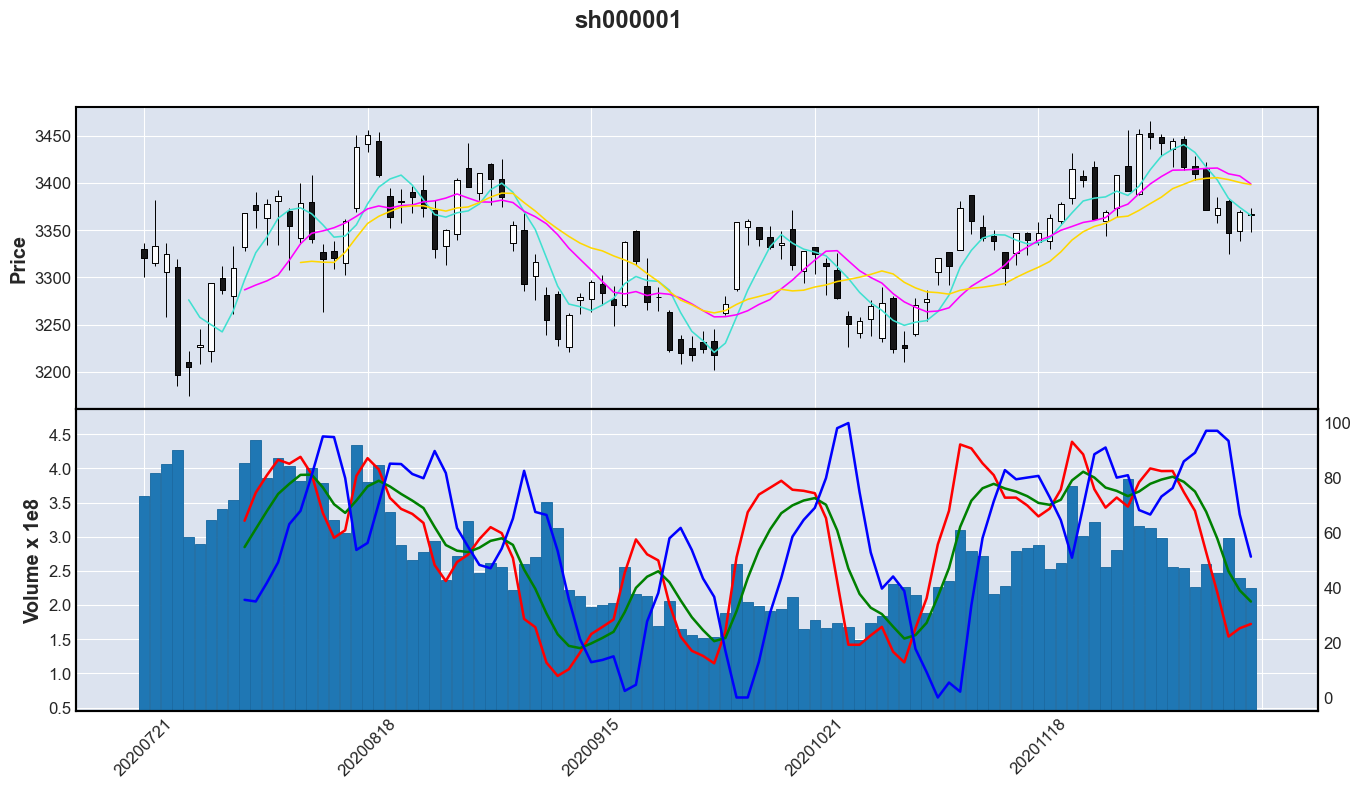

In [9]:
import mplfinance as mpf

symbol = "sh000001"
stock_data = pd.read_csv("./data/" + symbol + ".csv",
                             index_col=0, parse_dates=True)
stock_data.index.name = "Date"

stock_data = KDJ(stock_data)

# 添加KDJ
aps = [
    mpf.make_addplot(stock_data["K"], panel=1, color="r"),
    mpf.make_addplot(stock_data["D"], panel=1, color="g"),
    mpf.make_addplot(stock_data["J"], panel=1, color="b")
]

mpf.plot(stock_data, type='candle', mav=(5, 10, 15), volume=True,
            title=symbol, datetime_format="%Y%m%d", addplot=aps, panel_ratios=(1, 1), figratio=(2, 1), figscale=1.5)


## 基于机器学习的股票预测——一个简单实现

输入：过去9天的涨跌幅、K、D、J值作为输入（36个值）

输出：当日涨跌幅在-0.03~0.03之间为0，涨幅超过0.03为1，跌幅超过0.03为2。共三种输出，并标准化为3*1的数组。

### 预处理

将交易数据转化为神经网络模型的输入与输出。由于KDJ值的计算一开始会引入默认值50，故我们只采取一支股票第30天开始的数据，这样输入数据最早为第21个交易日的，以抹平在第9个交易日引入的默认值的影响。一支股票的交易数据可以为我们提供70组训练数据。

In [10]:
# 将交易数据转化为我们需要的输入与输出
def MLDataPrepare(symbol: str):
    stock_data = pd.read_csv("./data/" + symbol + ".csv",
                             index_col=0, parse_dates=True)
    stock_data.index.name = "Date"

    stock_data = KDJ(stock_data).reset_index()[
        ["close", "K", "D", "J"]].to_numpy()
    close_array = stock_data[:, 0]
    change_array = (close_array[1:] - close_array[:-1]) / close_array[:-1]
    change_array = np.insert(change_array, 0, 0)
    stock_data = np.column_stack((stock_data, change_array))
    stock_data = np.delete(stock_data, 0, 1)
    x_array = np.empty([0, 36])
    y_array = np.empty([0, 3])
    for i in range(30, 100):  # 自30日开始，以前9日的涨跌幅、KDJ值为输入，以当日涨跌幅为输出
        x = stock_data[i-9:i].flatten()
        c = stock_data[i, 3]
        y = [1, 0, 0]
        if c > 0.03:
            y = [0, 1, 0]
        elif c < -0.03:
            y = [0, 0, 1]
        x_array = np.row_stack((x_array, x))
        y_array = np.row_stack((y_array, y))
    return x_array, y_array

我们随机选取100支股票作为训练集，10支股票作为测试集，这样我们就会拥有7000组训练数据，700组测试数据。

In [11]:
stock_list = stock_list.sample(110).reset_index(
    drop=True)  # 挑选100家数据用于训练，10家用于测试


x_train = np.empty([0, 36])
y_train = np.empty([0, 3])
x_test = np.empty([0, 36])
y_test = np.empty([0, 3])

for i in range(100):
    x_array, y_array = MLDataPrepare(stock_list.at[i, "symbol"])
    x_train = np.row_stack((x_train, x_array))
    y_train = np.row_stack((y_train, y_array))
for i in range(100, 110):
    x_array, y_array = MLDataPrepare(stock_list.at[i, "symbol"])
    x_test = np.row_stack((x_test, x_array))
    y_test = np.row_stack((y_test, y_array))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 36)
(7000, 3)
(700, 36)
(700, 3)


准备炼丹炉。参数乱配的。

In [12]:
model = Sequential()
model.add(Dense(units=64, activation='sigmoid', input_dim=36))
model.add(Dense(units=16, activation='sigmoid'))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
print("==========进行训练==========")
model.fit(x_train, y_train, epochs=32, batch_size=500)

==========进行训练==========
Epoch 1/32
14/14 [==============================] - 0s 1ms/step - loss: 1.2958 - accuracy: 0.1043
Epoch 2/32
14/14 [==============================] - 0s 1000us/step - loss: 0.9775 - accuracy: 0.7499
Epoch 3/32
14/14 [==============================] - 0s 1000us/step - loss: 0.8028 - accuracy: 0.8134
Epoch 4/32
14/14 [==============================] - 0s 1000us/step - loss: 0.7249 - accuracy: 0.8036
Epoch 5/32
14/14 [==============================] - 0s 1000us/step - loss: 0.6849 - accuracy: 0.8005
Epoch 6/32
14/14 [==============================] - 0s 1ms/step - loss: 0.6495 - accuracy: 0.8095
Epoch 7/32
14/14 [==============================] - 0s 1ms/step - loss: 0.6317 - accuracy: 0.8130
Epoch 8/32
14/14 [==============================] - 0s 846us/step - loss: 0.6320 - accuracy: 0.8084
Epoch 9/32
14/14 [==============================] - 0s 846us/step - loss: 0.6254 - accuracy: 0.8103
Epoch 10/32
14/14 [==============================] - 0s 769us/step - loss: 0.

In [13]:
print("==========进行测试==========")
res = model.evaluate(x_test, y_test)
print("Loss: ", res[0])
print("Accuracy: ", res[1])

==========进行测试==========
22/22 [==============================] - 0s 620us/step - loss: 0.6832 - accuracy: 0.7800
Loss:  0.6831792593002319
Accuracy:  0.7799999713897705


我们的预测成功率在80%左右

## 参考

1. [股票接口](https://blog.csdn.net/luanpeng825485697/article/details/78442062)
2. [KDJ](https://wiki.mbalib.com/wiki/%E9%9A%8F%E6%9C%BA%E6%8C%87%E6%A0%87)
3. [mplfinance](https://github.com/matplotlib/mplfinance/)
